# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomResizedCrop(28),                                    
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      #  transforms.RandomAffine( degrees =0,translate=(0.1,0.1), scale=(0.9, 1.1),shear=(-10, 10, 20, 40)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [5]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
#             nn.BatchNorm2d(8),
#             nn.Dropout(dropout_value)
        ) # output_size = 26 
        #o/p size=16*26*26 RF=3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(dropout_value)
        ) # output_size = 24 
        #o/p size=32*24*24 RF=5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        #o/p size=10*24*24 RF=5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
         #o/p size=10*12*12 RF=6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
#             nn.Dropout(dropout_value)
        ) # output_size = 10
        #o/p size =16*10*10 RF=10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
#             nn.Dropout(dropout_value)
        ) # output_size = 8
        #o/p size = 16*8*8 RF = 14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        #o/p size = 16*6*6 RF = 18
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        #o/p size = 16*6*6 RF = 22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1
        #o/p size = 16*1*1 RF = 32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 
        #o/p size = 10*1*1 RF = 32


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,168
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5            [-1, 8, 24, 24]             128
         MaxPool2d-6            [-1, 8, 12, 12]               0
            Conv2d-7           [-1, 16, 10, 10]           1,152
              ReLU-8           [-1, 16, 10, 10]               0
       BatchNorm2d-9           [-1, 16, 10, 10]              32
           Conv2d-10             [-1, 16, 8, 8]           2,304
             ReLU-11             [-1, 16, 8, 8]               0
      BatchNorm2d-12             [-1, 16, 8, 8]              32
           Conv2d-13             [-1, 16, 6, 6]           2,304
             ReLU-14             [

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    reg = 1e-6
    l1_loss = torch.tensor(0., requires_grad=True)
    l1_loss=l1_loss.to(device)
    for name, param in model.named_parameters():
        if 'bias' not in name:
            l1_loss = l1_loss + reg*(torch.norm(param, 1))
    loss=loss+l1_loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.10481971502304077 Batch_id=468 Accuracy=92.07: 100%|██████████████████████████| 469/469 [00:31<00:00, 15.11it/s]



Test set: Average loss: 0.0872, Accuracy: 9737/10000 (97.37%)

EPOCH: 1


Loss=0.015771929174661636 Batch_id=468 Accuracy=97.90: 100%|█████████████████████████| 469/469 [00:30<00:00, 16.86it/s]



Test set: Average loss: 0.0572, Accuracy: 9819/10000 (98.19%)

EPOCH: 2


Loss=0.08504939824342728 Batch_id=468 Accuracy=98.45: 100%|██████████████████████████| 469/469 [00:30<00:00, 16.54it/s]



Test set: Average loss: 0.0290, Accuracy: 9906/10000 (99.06%)

EPOCH: 3


Loss=0.05069341883063316 Batch_id=468 Accuracy=98.59: 100%|██████████████████████████| 469/469 [00:30<00:00, 16.48it/s]



Test set: Average loss: 0.0271, Accuracy: 9918/10000 (99.18%)

EPOCH: 4


Loss=0.0749267190694809 Batch_id=468 Accuracy=98.83: 100%|███████████████████████████| 469/469 [00:30<00:00, 17.47it/s]



Test set: Average loss: 0.0250, Accuracy: 9926/10000 (99.26%)

EPOCH: 5


Loss=0.03417901322245598 Batch_id=468 Accuracy=98.86: 100%|██████████████████████████| 469/469 [00:30<00:00, 17.59it/s]



Test set: Average loss: 0.0236, Accuracy: 9923/10000 (99.23%)

EPOCH: 6


Loss=0.04520006850361824 Batch_id=468 Accuracy=98.92: 100%|██████████████████████████| 469/469 [00:29<00:00, 18.72it/s]



Test set: Average loss: 0.0248, Accuracy: 9920/10000 (99.20%)

EPOCH: 7


Loss=0.020358312875032425 Batch_id=468 Accuracy=98.98: 100%|█████████████████████████| 469/469 [00:27<00:00, 18.49it/s]



Test set: Average loss: 0.0223, Accuracy: 9932/10000 (99.32%)

EPOCH: 8


Loss=0.012164277024567127 Batch_id=468 Accuracy=99.05: 100%|█████████████████████████| 469/469 [00:28<00:00, 18.73it/s]



Test set: Average loss: 0.0188, Accuracy: 9942/10000 (99.42%)

EPOCH: 9


Loss=0.015012800693511963 Batch_id=468 Accuracy=99.10: 100%|█████████████████████████| 469/469 [00:28<00:00, 18.69it/s]



Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99.37%)

EPOCH: 10


Loss=0.0439424104988575 Batch_id=468 Accuracy=99.16: 100%|███████████████████████████| 469/469 [00:27<00:00, 18.79it/s]



Test set: Average loss: 0.0172, Accuracy: 9946/10000 (99.46%)

EPOCH: 11


Loss=0.009238000027835369 Batch_id=468 Accuracy=99.17: 100%|█████████████████████████| 469/469 [00:28<00:00, 18.87it/s]



Test set: Average loss: 0.0185, Accuracy: 9945/10000 (99.45%)

EPOCH: 12


Loss=0.023468777537345886 Batch_id=468 Accuracy=99.22: 100%|█████████████████████████| 469/469 [00:28<00:00, 18.28it/s]



Test set: Average loss: 0.0159, Accuracy: 9949/10000 (99.49%)

EPOCH: 13


Loss=0.04598468914628029 Batch_id=468 Accuracy=99.24: 100%|██████████████████████████| 469/469 [00:30<00:00, 17.68it/s]



Test set: Average loss: 0.0220, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.04042401164770126 Batch_id=468 Accuracy=99.23: 100%|██████████████████████████| 469/469 [00:29<00:00, 18.08it/s]



Test set: Average loss: 0.0192, Accuracy: 9938/10000 (99.38%)

EPOCH: 15


Loss=0.07463973015546799 Batch_id=468 Accuracy=99.27: 100%|██████████████████████████| 469/469 [00:29<00:00, 18.45it/s]



Test set: Average loss: 0.0180, Accuracy: 9935/10000 (99.35%)

EPOCH: 16


Loss=0.008568603545427322 Batch_id=468 Accuracy=99.31: 100%|█████████████████████████| 469/469 [00:28<00:00, 18.58it/s]



Test set: Average loss: 0.0185, Accuracy: 9940/10000 (99.40%)

EPOCH: 17


Loss=0.061542708426713943 Batch_id=468 Accuracy=99.34: 100%|█████████████████████████| 469/469 [00:28<00:00, 18.13it/s]



Test set: Average loss: 0.0191, Accuracy: 9928/10000 (99.28%)

EPOCH: 18


Loss=0.010814491659402847 Batch_id=468 Accuracy=99.35: 100%|█████████████████████████| 469/469 [00:28<00:00, 18.59it/s]



Test set: Average loss: 0.0188, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.021669020876288414 Batch_id=468 Accuracy=99.39: 100%|█████████████████████████| 469/469 [00:28<00:00, 18.64it/s]



Test set: Average loss: 0.0160, Accuracy: 9947/10000 (99.47%)

EPOCH: 20


Loss=0.023750094696879387 Batch_id=468 Accuracy=99.32: 100%|█████████████████████████| 469/469 [00:28<00:00, 18.63it/s]



Test set: Average loss: 0.0175, Accuracy: 9936/10000 (99.36%)

EPOCH: 21


Loss=0.07969272136688232 Batch_id=468 Accuracy=99.39: 100%|██████████████████████████| 469/469 [00:29<00:00, 14.07it/s]



Test set: Average loss: 0.0202, Accuracy: 9932/10000 (99.32%)

EPOCH: 22


Loss=0.08441801369190216 Batch_id=468 Accuracy=99.42: 100%|██████████████████████████| 469/469 [00:17<00:00, 26.23it/s]



Test set: Average loss: 0.0136, Accuracy: 9957/10000 (99.57%)

EPOCH: 23


Loss=0.025278527289628983 Batch_id=468 Accuracy=99.46: 100%|█████████████████████████| 469/469 [00:17<00:00, 27.55it/s]



Test set: Average loss: 0.0189, Accuracy: 9929/10000 (99.29%)

EPOCH: 24


Loss=0.022120710462331772 Batch_id=468 Accuracy=99.47: 100%|█████████████████████████| 469/469 [00:17<00:00, 27.53it/s]



Test set: Average loss: 0.0180, Accuracy: 9937/10000 (99.37%)

EPOCH: 25


Loss=0.01618209481239319 Batch_id=468 Accuracy=99.42: 100%|██████████████████████████| 469/469 [00:16<00:00, 31.40it/s]



Test set: Average loss: 0.0156, Accuracy: 9943/10000 (99.43%)

EPOCH: 26


Loss=0.003645770251750946 Batch_id=468 Accuracy=99.42: 100%|█████████████████████████| 469/469 [00:16<00:00, 27.83it/s]



Test set: Average loss: 0.0177, Accuracy: 9937/10000 (99.37%)

EPOCH: 27


Loss=0.031130986288189888 Batch_id=468 Accuracy=99.46: 100%|█████████████████████████| 469/469 [00:17<00:00, 27.07it/s]



Test set: Average loss: 0.0186, Accuracy: 9937/10000 (99.37%)

EPOCH: 28


Loss=0.02978118136525154 Batch_id=468 Accuracy=99.42: 100%|██████████████████████████| 469/469 [00:16<00:00, 30.45it/s]



Test set: Average loss: 0.0162, Accuracy: 9943/10000 (99.43%)

EPOCH: 29


Loss=0.004982692189514637 Batch_id=468 Accuracy=99.39: 100%|█████████████████████████| 469/469 [00:17<00:00, 26.47it/s]



Test set: Average loss: 0.0161, Accuracy: 9951/10000 (99.51%)

EPOCH: 30


Loss=0.02504626102745533 Batch_id=468 Accuracy=99.48: 100%|██████████████████████████| 469/469 [00:18<00:00, 25.77it/s]



Test set: Average loss: 0.0165, Accuracy: 9939/10000 (99.39%)

EPOCH: 31


Loss=0.0040674274787306786 Batch_id=468 Accuracy=99.50: 100%|████████████████████████| 469/469 [00:16<00:00, 30.38it/s]



Test set: Average loss: 0.0168, Accuracy: 9949/10000 (99.49%)

EPOCH: 32


Loss=0.016503868624567986 Batch_id=468 Accuracy=99.47: 100%|█████████████████████████| 469/469 [00:17<00:00, 27.56it/s]



Test set: Average loss: 0.0170, Accuracy: 9945/10000 (99.45%)

EPOCH: 33


Loss=0.07491788268089294 Batch_id=468 Accuracy=99.53: 100%|██████████████████████████| 469/469 [00:16<00:00, 27.65it/s]



Test set: Average loss: 0.0200, Accuracy: 9938/10000 (99.38%)

EPOCH: 34


Loss=0.0066713737323880196 Batch_id=468 Accuracy=99.50: 100%|████████████████████████| 469/469 [00:17<00:00, 27.12it/s]



Test set: Average loss: 0.0146, Accuracy: 9952/10000 (99.52%)

EPOCH: 35


Loss=0.007502913940697908 Batch_id=468 Accuracy=99.51: 100%|█████████████████████████| 469/469 [00:17<00:00, 27.54it/s]



Test set: Average loss: 0.0201, Accuracy: 9933/10000 (99.33%)

EPOCH: 36


Loss=0.04472287744283676 Batch_id=468 Accuracy=99.53: 100%|██████████████████████████| 469/469 [00:16<00:00, 28.18it/s]



Test set: Average loss: 0.0201, Accuracy: 9937/10000 (99.37%)

EPOCH: 37


Loss=0.04011189565062523 Batch_id=468 Accuracy=99.56: 100%|██████████████████████████| 469/469 [00:17<00:00, 27.41it/s]



Test set: Average loss: 0.0178, Accuracy: 9948/10000 (99.48%)

EPOCH: 38


Loss=0.0037606703117489815 Batch_id=468 Accuracy=99.53: 100%|████████████████████████| 469/469 [00:17<00:00, 27.48it/s]



Test set: Average loss: 0.0164, Accuracy: 9944/10000 (99.44%)

EPOCH: 39


Loss=0.056702110916376114 Batch_id=468 Accuracy=99.56: 100%|█████████████████████████| 469/469 [00:21<00:00, 21.93it/s]



Test set: Average loss: 0.0165, Accuracy: 9943/10000 (99.43%)



Text(0.5, 1.0, 'Test Accuracy')

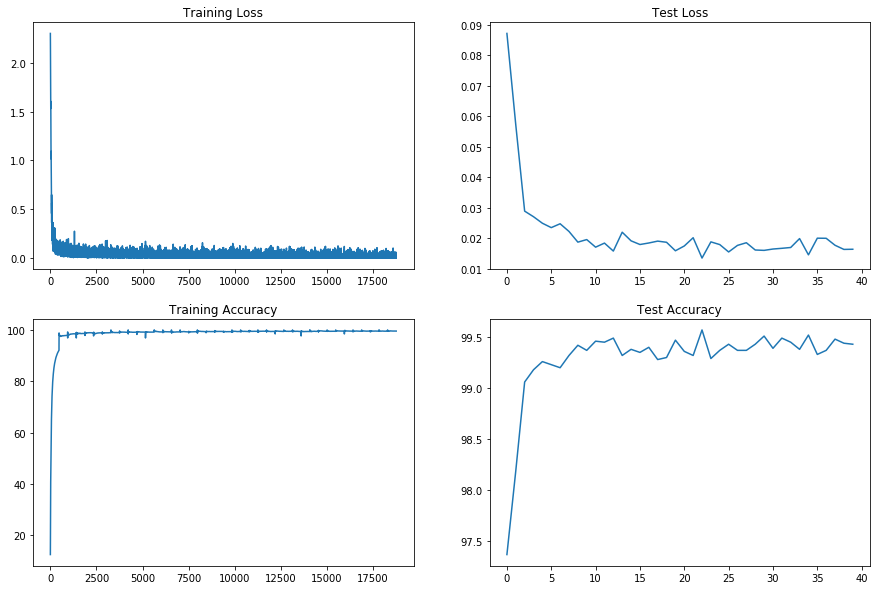

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

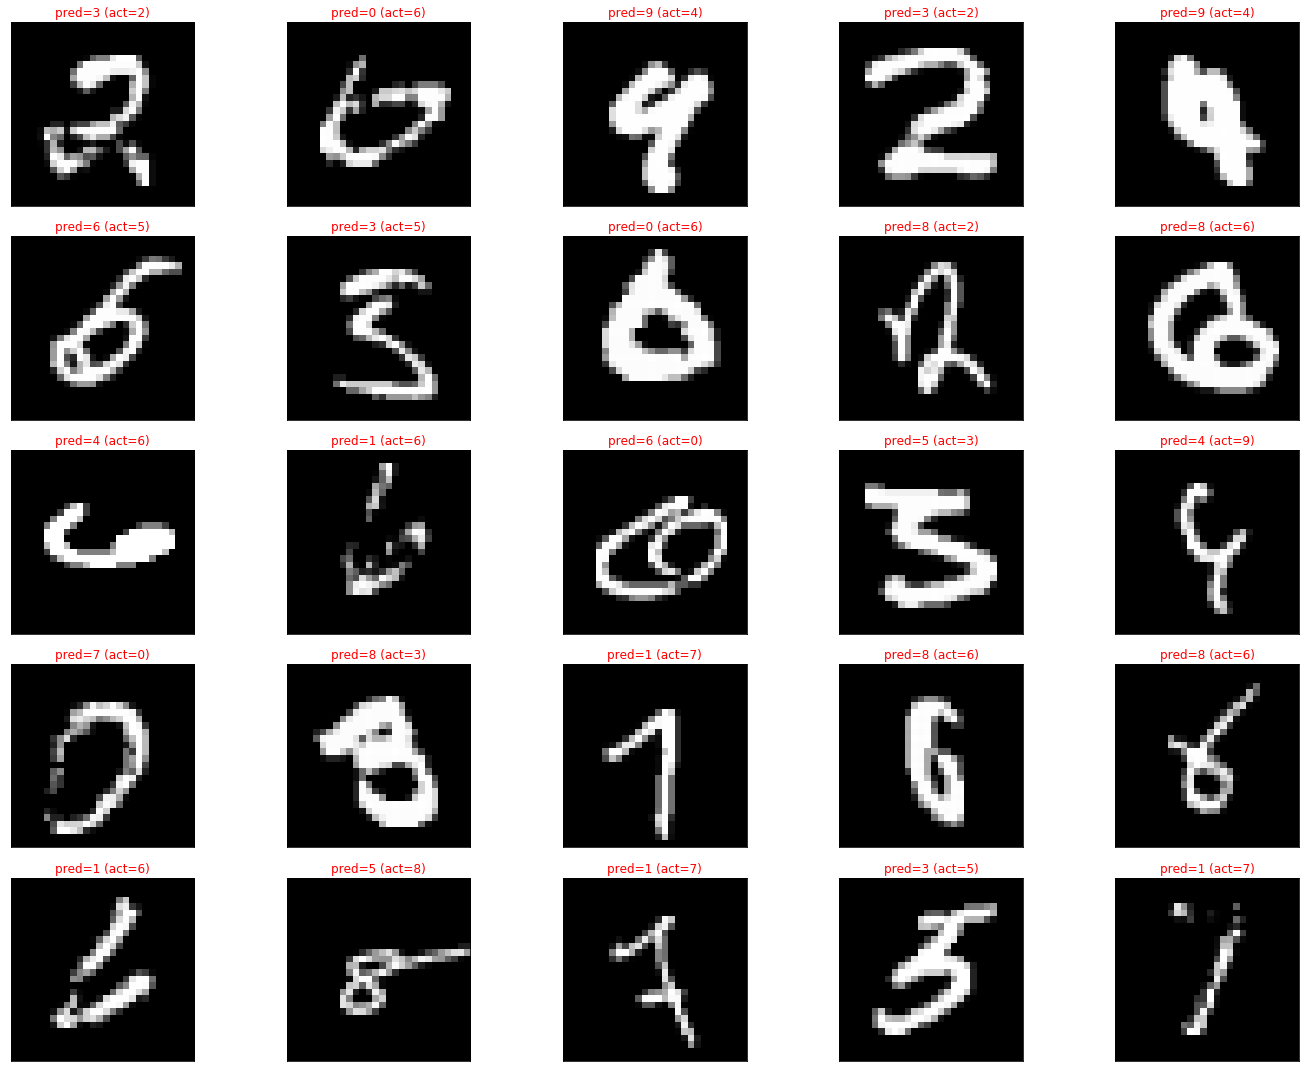

In [13]:
import numpy as np
counter=1
fig = plt.figure(figsize=(20, 15))
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    # convert output probabilities to predicted class
    _, preds = torch.max(output, 1)
    images = data.cpu().numpy()
    #print(np.arange(len(preds.cpu().numpy())))

    if counter < 26:

        for idx in np.arange(len(preds.cpu().numpy())):
            if preds[idx]!=target[idx]:
                ax = fig.add_subplot(5, 5, counter, xticks=[], yticks=[])
                ax.imshow(np.squeeze(images[idx]), cmap='gray')
                ax.set_title("pred={} (act={})".format(str(preds[idx].item()), str(target[idx].item())),
                             color= "red")
            
                counter+=1
        
    else:
        break
        
fig.tight_layout()  
plt.show()